binning process

In [1]:
import numpy as np
import pandas as pd   
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn.metrics as metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from optbinning import BinningProcess

(CVXPY) Jun 04 02:41:39 PM: Encountered unexpected exception importing solver GLOP:
RuntimeError('Unrecognized new version of ortools (9.6.2534). Expected < 9.5.0.Please open a feature request on cvxpy to enable support for this version.')
(CVXPY) Jun 04 02:41:39 PM: Encountered unexpected exception importing solver PDLP:
RuntimeError('Unrecognized new version of ortools (9.6.2534). Expected < 9.5.0.Please open a feature request on cvxpy to enable support for this version.')


In [2]:
df = pd.read_parquet('german_credit_data.parquet').drop('Unnamed: 0', axis=1)

In [3]:
df = df.rename(columns = {
    'Sex': 'Gender',
    'Saving accounts': 'Saving_acc',
    'Checking account': 'Checking_acc',
    'Credit amount': 'Credit_mnt',
})

df.Gender = df.Gender.apply(lambda x: 1 if x == 'male' else 0)
df.Risk = df.Risk.apply(lambda x: 1 if x == 'good' else 0)

df.Saving_acc = df.Saving_acc.map({
    None: 'none',
    'little': 'low',
    'moderate': 'medium',
    'quite rich': 'high',
    'rich': 'high'
})
df.Checking_acc = df.Checking_acc.map({
    None: 'none',
    'little': 'low',
    'moderate': 'medium',
    'rich': 'high'
})

df.Purpose = df.Purpose.str.replace('/', '_').str.replace(' ', '_')

In [4]:
y = df.Risk
X = df.loc[:, df.columns != 'Risk']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [5]:
categorical = ['Job', 'Housing', 'Saving_acc', 'Checking_acc', 'Purpose']
continuous = ['Age', 'Credit_mnt', 'Duration']

In [6]:
cn_binning_process = BinningProcess(continuous)
ct_binning_process = BinningProcess(categorical)

In [7]:
X_train[continuous] = cn_binning_process.fit_transform(
    X_train[continuous], y_train
).values

X_train[categorical] = ct_binning_process.fit_transform(
    X_train[categorical], y_train
).values

In [8]:
X_test[continuous] = cn_binning_process.fit_transform(
    X_test[continuous], y_test
).values

X_test[categorical] = ct_binning_process.fit_transform(
    X_test[categorical], y_test
).values

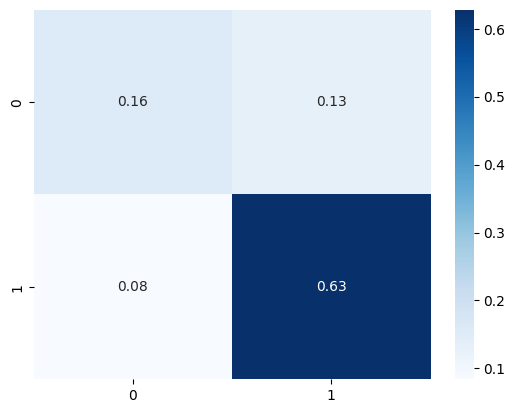

Accuracy score:  0.78
F1 score:        0.85
Precision score: 0.83
Recall score:    0.88


In [9]:
model = LogisticRegression(random_state=0)

model.fit(X_train, y_train)
y_predicted = model.predict(X_test)

sns.heatmap(
    metrics.confusion_matrix(y_test, y_predicted, normalize='all'),
    cmap='Blues', annot=True, fmt='.2f'
)
plt.show()

print('Accuracy score:  {:.2f}'.format( metrics.accuracy_score(y_test, y_predicted) ))
print('F1 score:        {:.2f}'.format( metrics.f1_score(y_test, y_predicted) ))
print('Precision score: {:.2f}'.format( metrics.precision_score(y_test, y_predicted) ))
print('Recall score:    {:.2f}'.format( metrics.recall_score(y_test, y_predicted) ))